In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
import os
env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
os.environ["LACE_MANAGER_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE_manager"

In [3]:
from lace.emulator_nn.network import MDNemulator_polyfit
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.test_simulation_nn import test_sim
from lace.emulator import pd_archive

/data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?


In [4]:
# our modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import poly_p1d
from lace.emulator import pd_archive

In [5]:
def sigma68(data): return 0.5*(np.nanquantile(data,q = 0.84,axis = 0) - np.nanquantile(data,q = 0.16,axis = 0))


In [6]:
emuparams = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
initial_weights='/nfs/pic.es/user/l/lcabayol/DESI/notebooks_paper_GPvsNN/notebooks_tests/initial_weights_7deg.pt'


## TEST OTHER COSMOLOGIES

### Neural network

In [35]:
cosmos = ['central','diffseed','h','nu','running','curved','diffigm']

fractional_errors=np.zeros((len(cosmos), 11, 85))
emu_p1derrs=np.zeros((len(cosmos), 11, 85))
emu_p1ds = np.zeros((len(cosmos), 11, 85))
true_p1ds=np.zeros((len(cosmos), 11, 85))


emulator = emulator_train(emuparams, zmax=4.5, Nsim=30, nepochs=100, step_size=75, postprocessing='768', list_archives=['data_input_axes','data_input_phases'],initial_weights=None, drop_sim=None, kmax_Mpc=8, ndeg=7)
for i,c in enumerate(cosmos):

    truth=pd_archive.archivePD(z_max=4.5,nsamples=30, pick_sim=c)
    truth.average_over_samples(flag="all")
    zs = [d['z'] for d in truth.data_av_all if d['scale_tau'] == 1] 
    truth = [d for d in truth.data_av_all if d['scale_tau'] == 1] 
    
       
    fractional_error, emu_p1d, true_p1d, emu_p1derr = test_sim(emulator.emulator, truth, emuparams, emulator.paramLims, emulator.device, emulator.yscalings,  kmax_Mpc_test=8, ndeg=7 )

    fractional_errors[i] = fractional_error
    emu_p1ds[i] = emu_p1d
    true_p1ds[i] = true_p1d
    emu_p1derrs[i] = emu_p1derr


start the training of the emulator
Training network on 11550
Emualtor trained in 90.73171782493591 seconds
85
Mean fractional error: 0.9939665788338842
Std fractional error: 0.010523695928989356
85
Mean fractional error: 0.9947630547345994
Std fractional error: 0.01076764804743388
85
Mean fractional error: 0.994589129801685
Std fractional error: 0.01163636323965571
Sim has neutrinos
85
Mean fractional error: 0.9939495742717381
Std fractional error: 0.012763295342870613
85
Mean fractional error: 0.9888350106088749
Std fractional error: 0.014753166354477504
85
Mean fractional error: 0.9942805921272687
Std fractional error: 0.010479602604955267
85
Mean fractional error: 0.982843832316263
Std fractional error: 0.03734235099193999


In [8]:
# make pretty plots
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 22}
matplotlib.rc('font', **font)
plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [36]:
fractional_errors = (fractional_errors -1)*100

Text(0.5, 0, '$z$')

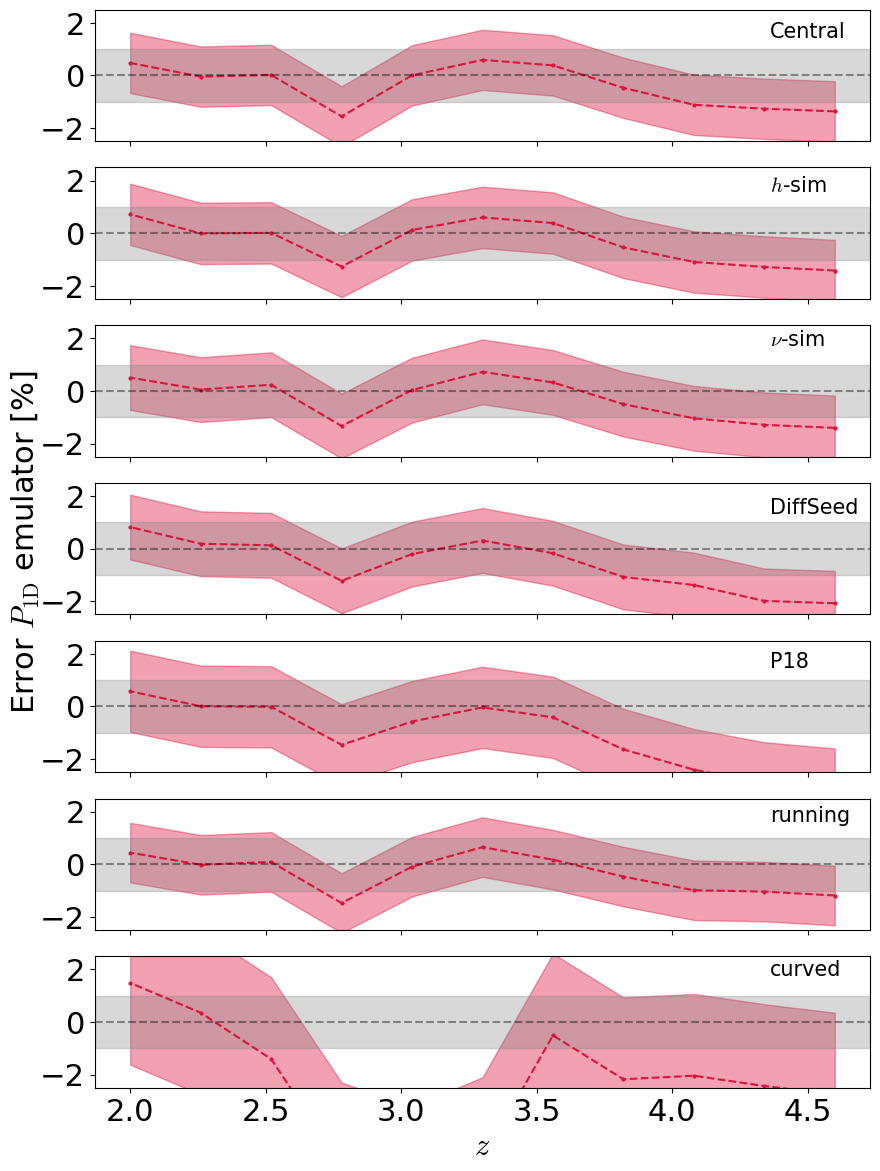

In [10]:
colors = ['crimson']
fig, ax = plt.subplots(ncols=1, nrows= len(cosmos),figsize = (10,2*len(cosmos)), sharey=True, sharex=True)
zaxis = np.flip(np.linspace(2.,4.6,11))

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15 )


for c in range(len(cosmos)):
    ax[c].plot(zaxis, np.nanmedian(fractional_errors[c],1), ls = '--', marker = 'o',markersize=2, color = colors[0])
    ax[c].fill_between(zaxis, np.nanmedian(fractional_errors[c],1) - sigma68(fractional_errors[c].flatten()),np.nanmedian(fractional_errors[c],1) + sigma68(fractional_errors[c].flatten()), color = colors[0], alpha = 0.4)
    ax[c].axhspan(-1,1,color="gray",alpha=0.3)
    ax[c].axhline(y=0,color="black",ls='--', alpha =0.4)


#ax[1].plot(zaxis, np.nanmedian(fractional_error_h,1), ls = '--', marker = 'o',markersize=2, color = 'crimson')
#ax[1].fill_between(zaxis, np.nanmedian(fractional_error_h,1) - sigma68(np.nanmedian(fractional_error_h,1)),np.nanmedian(fractional_error_h,1) + sigma68(np.nanmedian(fractional_error_h,1)), color = 'crimson', alpha = 0.4)


ax[0].set_ylim(-2.5,2.5)

#plt.ylabel(r'Percent error', fontsize = 14)


fig.text(0.04, 0.5, r'Error $P_{\rm 1D}$ emulator [%]', va='center', rotation='vertical')
fig.text(0.8, 0.86, r'Central',fontsize = 15)
fig.text(0.8, 0.75, r'$h$-sim',fontsize = 15)
fig.text(0.8, 0.64, r'$\nu$-sim',fontsize = 15)
fig.text(0.8, 0.52, r'DiffSeed',fontsize = 15)
fig.text(0.8, 0.41, r'P18',fontsize = 15)
fig.text(0.8, 0.3, r'running',fontsize = 15)
fig.text(0.8, 0.19, r'curved',fontsize = 15)
plt.xlabel(r"$z$")



#plt.savefig('other_cosmologies_extended.pdf', bbox_inches = 'tight')

### Gaussian process

In [11]:
emu_type = 'polyfit'
training=pd_archive.archivePD(z_max=4.5,nsamples=30)
training.average_over_samples(flag="all")
training.average_over_samples(flag="phases")
training.average_over_samples(flag="axes")
training.input_emulator(flag="all")
training.input_emulator(flag="phases")
training.input_emulator(flag="axes")
training.data_av_all = [d for d in training.data_av_all if d['scale_tau'] == 1] 

In [12]:
kmax_Mpc=8
ndeg=7
sim_zs=[data['z'] for data in training.data]
Nz=len(sim_zs)
sim_k_Mpc=training.data[0]['k_Mpc']
Nk=len(sim_k_Mpc)
k_mask=(sim_k_Mpc<kmax_Mpc) & (sim_k_Mpc>0)
sim_k_Mpc=sim_k_Mpc[k_mask]
Nk=len(sim_k_Mpc)
kmax_Mpc=8

emu_test=gp_emulator.GPEmulator(z_max=4.5,kmax_Mpc=kmax_Mpc,ndeg=ndeg,
                        train=True,asymmetric_kernel=True,rbf_only=True,
                        passarchive=training,emu_type=emu_type,check_hull=False, key_data='data_av_all')



 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.49 seconds


In [13]:
fractional_errors_gp=np.zeros((len(cosmos), 11, 85))
cosmos = ['central','diffseed','h','nu','running','curved','diffigm']
for i,c in enumerate(cosmos):

    truth=pd_archive.archivePD(z_max=4.5, pick_sim=c)
    truth.average_over_samples(flag="all")
    truth = [d for d in truth.data_av_all if d['scale_tau'] == 1] 
    
    for aa,item in enumerate(truth):
        # figure out redshift for this entry
        z=item["z"]

        true_k=item["k_Mpc"]
        k_mask=(true_k<kmax_Mpc) & (true_k>0)
        true_p1d=item["p1d_Mpc"][k_mask]
        coeff_p1d = poly_p1d.PolyP1D(true_k[k_mask],true_p1d,kmin_Mpc=1.e-3,kmax_Mpc=kmax_Mpc,deg=ndeg).lnP_fit
        poly=np.poly1d(coeff_p1d)
        true_p1d_poly =np.exp(poly(np.log(true_k[k_mask])))

        # true p1d (some sims have an extra k bin, so we need to define mask again)
        true_k=item["k_Mpc"]
        k_mask=(true_k<kmax_Mpc) & (true_k>0)
        true_p1d=item["p1d_Mpc"][k_mask]
        assert len(true_p1d)==Nk


        #plt.loglog(true_k[k_mask],true_p1d, label = 'true')
        #plt.loglog(true_k[k_mask],true_p1d_poly, label = 'polyfit')
        #plt.legend()
        #plt.show()

        # for each entry, figure emulator parameter describing it (labels)
        emu_call={}
        for bb,param in enumerate(emu_test.paramList):
            emu_call[param]=item[param]

        # ask emulator to emulate P1D (and its uncertainty)
        emu_p1d,emu_err=emu_test.emulate_p1d_Mpc(emu_call,sim_k_Mpc,return_covar=True)
        fractional_errors_gp[i,aa] = emu_p1d/true_p1d_poly
    print(f'mean fractional error: {np.mean(fractional_errors_gp[i])}')
    print(f'std fractional error: {np.std(fractional_errors_gp[i])}')



mean fractional error: 0.9881349955328396
std fractional error: 0.020798721557407265
mean fractional error: 0.9893222604319725
std fractional error: 0.01989736860827944
mean fractional error: 0.9878158868077328
std fractional error: 0.021360251002519752
Sim has neutrinos
mean fractional error: 0.9886331755510288
std fractional error: 0.019330650094214853
mean fractional error: 0.9829671392054224
std fractional error: 0.016669620825564113
mean fractional error: 0.9872925018594682
std fractional error: 0.02156773308037305
mean fractional error: 1.0509147981191655
std fractional error: 0.06577364874207356


In [14]:
fractional_errors_gp = (fractional_errors_gp-1)*100

Text(0.5, 0, '$z$')

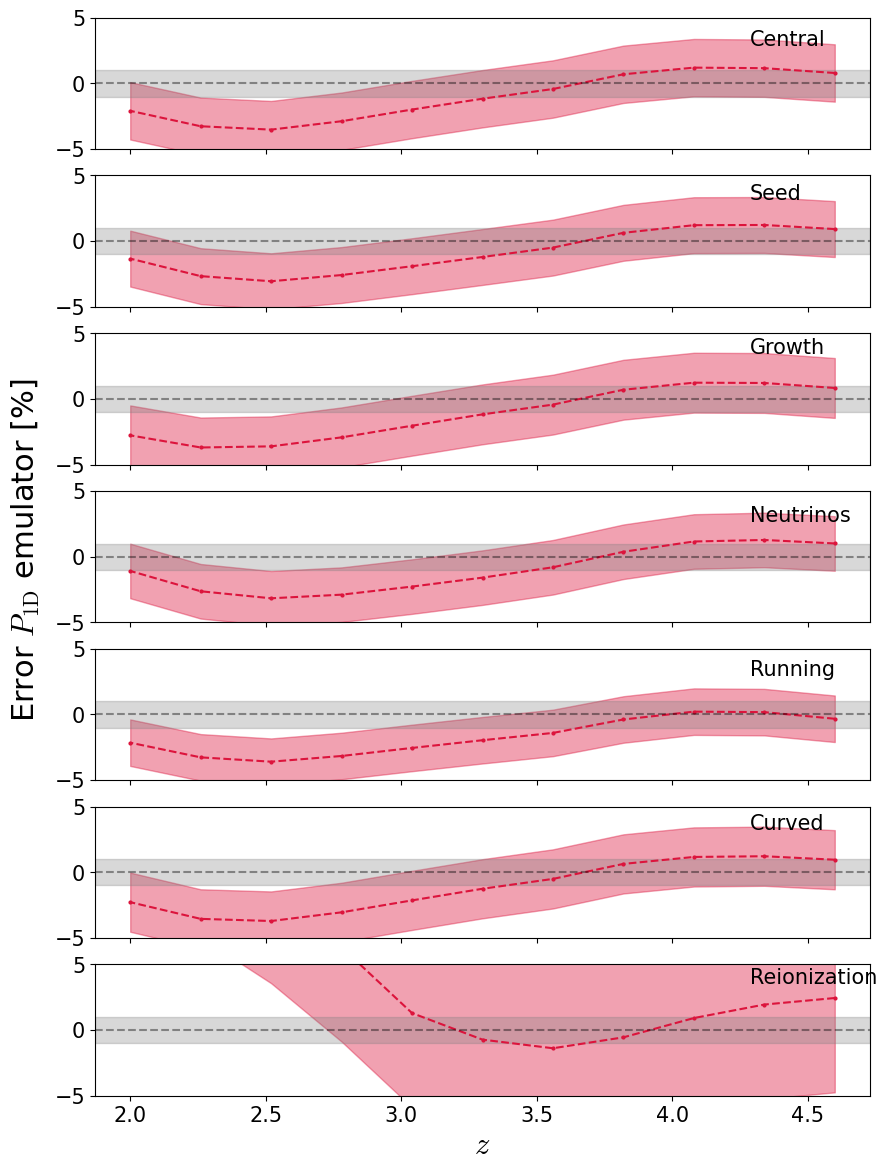

In [15]:
colors = ['crimson']
fig, ax = plt.subplots(ncols=1, nrows= len(cosmos),figsize = (10,2*len(cosmos)), sharey=True, sharex=True)
zaxis = np.flip(np.linspace(2.,4.6,11))

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15 )


for c in range(len(cosmos)):
    ax[c].plot(zaxis, np.nanmedian(fractional_errors_gp[c],1), ls = '--', marker = 'o',markersize=2, color = colors[0])
    ax[c].fill_between(zaxis, np.nanmedian(fractional_errors_gp[c],1) - sigma68(fractional_errors_gp[c].flatten()),np.nanmedian(fractional_errors_gp[c],1) + sigma68(fractional_errors_gp[c].flatten()), color = colors[0], alpha = 0.4)
    ax[c].axhspan(-1,1,color="gray",alpha=0.3)
    ax[c].axhline(y=0,color="black",ls='--', alpha =0.4)


#ax[1].plot(zaxis, np.nanmedian(fractional_error_h,1), ls = '--', marker = 'o',markersize=2, color = 'crimson')
#ax[1].fill_between(zaxis, np.nanmedian(fractional_error_h,1) - sigma68(np.nanmedian(fractional_error_h,1)),np.nanmedian(fractional_error_h,1) + sigma68(np.nanmedian(fractional_error_h,1)), color = 'crimson', alpha = 0.4)


ax[0].set_ylim(-5,5)

#plt.ylabel(r'Percent error', fontsize = 14)



fig.text(0.04, 0.5, r'Error $P_{\rm 1D}$ emulator [%]', va='center', rotation='vertical')
fig.text(0.78, 0.86, r'Central',fontsize = 15)
fig.text(0.78, 0.75, r'Seed',fontsize = 15)
fig.text(0.78, 0.64, r'Growth',fontsize = 15)
fig.text(0.78, 0.52, r'Neutrinos',fontsize = 15)
fig.text(0.78, 0.41, r'Running',fontsize = 15)
fig.text(0.78, 0.3, r'Curved',fontsize = 15)
fig.text(0.78, 0.19, r'Reionization',fontsize = 15)
plt.xlabel(r"$z$")





In [16]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

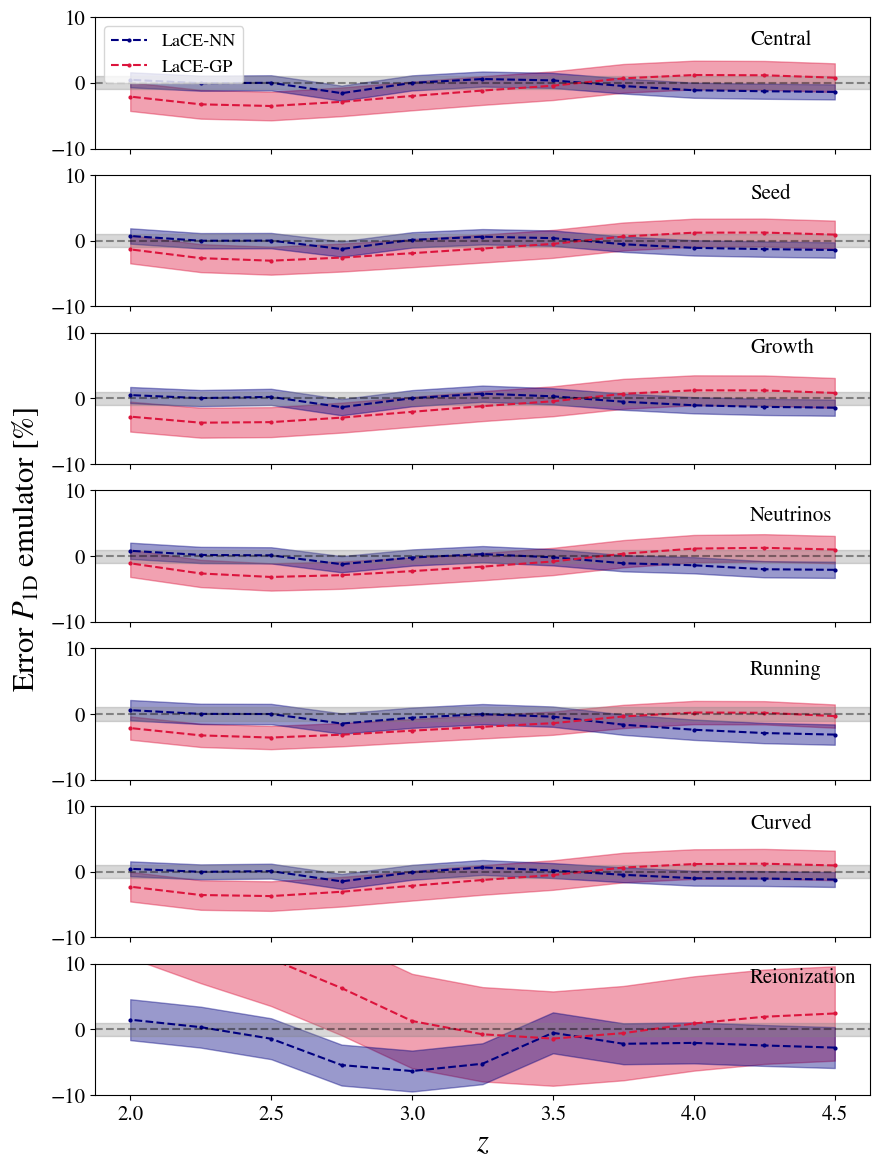

In [17]:
colors = ['crimson','navy', 'forestgreen', 'goldenrod']
fig, ax = plt.subplots(ncols=1, nrows= len(cosmos),figsize = (10,2*len(cosmos)), sharey=True, sharex=True)
zaxis =np.flip(np.linspace(2.,4.5,11))
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18 )


for c in range(len(cosmos)):
    ax[c].plot(zaxis, np.nanmedian(fractional_errors[c],1), ls = '--', marker = 'o',markersize=2, color = 'navy', label = 'LaCE-NN')
    ax[c].plot(zaxis, np.nanmedian(fractional_errors_gp[c],1), ls = '--', marker = 'o',markersize=2, color = 'crimson', label = 'LaCE-GP')
    ax[c].fill_between(zaxis, np.nanmedian(fractional_errors_gp[c],1) - sigma68(fractional_errors_gp[c].flatten()),np.nanmedian(fractional_errors_gp[c],1) + sigma68(fractional_errors_gp[c].flatten()), color = 'crimson', alpha = 0.4)
    ax[c].fill_between(zaxis, np.nanmedian(fractional_errors[c],1) - sigma68(fractional_errors[c].flatten()),np.nanmedian(fractional_errors[c],1) + sigma68(fractional_errors[c].flatten()), color = 'navy', alpha = 0.4)

    #ax[c].fill_between(zaxis, np.nanmedian(fractional_errors_gp[c],1) - np.std(fractional_errors_gp[c].flatten()),np.nanmedian(fractional_errors_gp[c],1) + np.std(fractional_errors_gp[c].flatten()), color = 'crimson', alpha = 0.4)
    #ax[c].fill_between(zaxis, np.nanmedian(fractional_errors[c],1) - np.std(fractional_errors[c].flatten()),np.nanmedian(fractional_errors[c],1) + np.std(fractional_errors[c].flatten()), color = 'navy', alpha = 0.4)

    
    ax[c].axhspan(-1,1,color="gray",alpha=0.3)
    ax[c].axhline(y=0,color="black",ls='--', alpha =0.4)


ax[0].set_ylim(-10,10)
ax[0].legend(loc = 2, fontsize= 13)

#plt.ylabel(r'Percent error', fontsize = 14)



fig.text(0.04, 0.5, r'Error $P_{\rm 1D}$ emulator [%]', va='center', rotation='vertical')
fig.text(0.78, 0.86, r'Central',fontsize = 15)
fig.text(0.78, 0.75, r'Seed',fontsize = 15)
fig.text(0.78, 0.64, r'Growth',fontsize = 15)
fig.text(0.78, 0.52, r'Neutrinos',fontsize = 15)
fig.text(0.78, 0.41, r'Running',fontsize = 15)
fig.text(0.78, 0.3, r'Curved',fontsize = 15)
fig.text(0.78, 0.19, r'Reionization',fontsize = 15)
plt.xlabel(r"$z$")


plt.savefig('other_cosmologies_extended_comparison.pdf', bbox_inches = 'tight')

Text(0.5, 0, '$k_{\\parallel}$ [1/Mpc]')

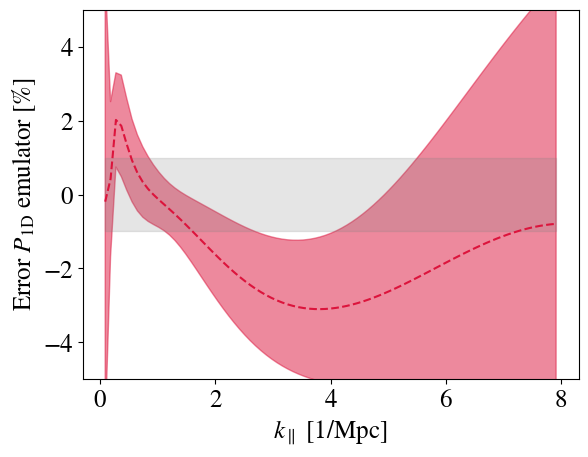

In [18]:
plt.fill_between(emulator.sim_k_Mpc[:85],fractional_errors[-1].mean(0)-np.std(fractional_errors[-1],0), fractional_errors[-1].mean(0)+np.std(fractional_errors[-1],0) ,color ='crimson', alpha=0.5)
plt.plot(emulator.sim_k_Mpc[:85],fractional_errors[-1].mean(0),color ='crimson', ls='--')
plt.ylim(-5,5)
plt.fill_between(emulator.sim_k_Mpc[:85],-1,1, color='grey', alpha=0.2)
plt.ylabel(r'Error $P_{\rm 1D}$ emulator [%]', fontsize=18)
plt.xlabel(r'$k_{\parallel}$ [1/Mpc]', fontsize=18)
#plt.savefig('P18_extended.pdf', bbox_inches='tight')

Text(0.5, 0, '$k_{\\parallel}$ [1/Mpc]')

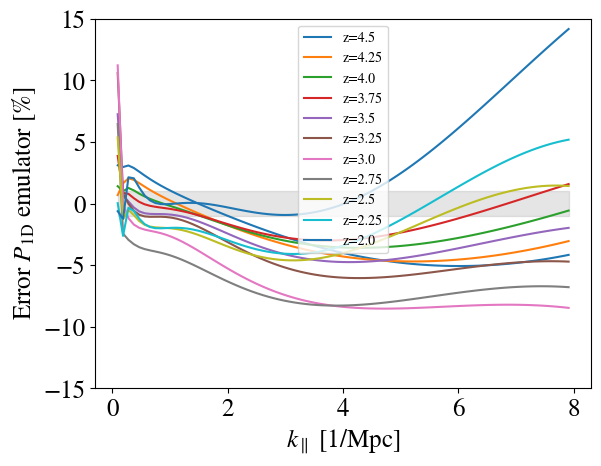

In [20]:
for i in range(11):
    plt.plot(emulator.sim_k_Mpc[:85],fractional_errors[-1,i], label = f'z={zs[i]}')
plt.ylim(-15,15)
plt.fill_between(emulator.sim_k_Mpc[:85],-1,1, color='grey', alpha=0.2)
plt.legend(fontsize=10)
plt.ylabel(r'Error $P_{\rm 1D}$ emulator [%]', fontsize=18)
plt.xlabel(r'$k_{\parallel}$ [1/Mpc]', fontsize=18)


Text(0.5, 0, '$k_{\\parallel}$ [1/Mpc]')

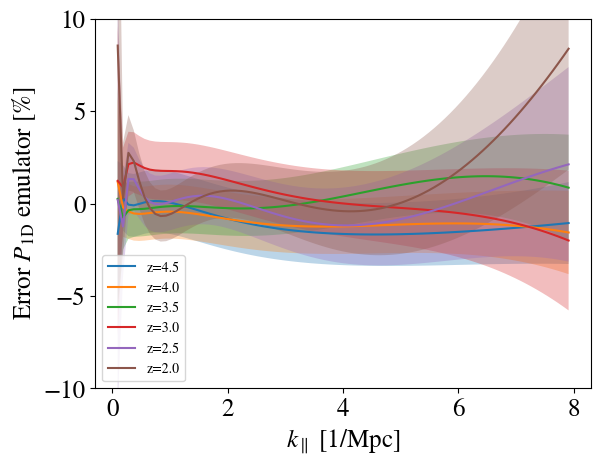

In [19]:
for i in np.arange(0,11,2):
#for i in range(0,1):

    plt.plot(emulator.sim_k_Mpc[:85],fractional_errors[0,i], label = f'z={zs[i]}')
    plt.fill_between(emulator.sim_k_Mpc[:85],fractional_errors[0,i]-emu_p1derrs[0,i]/true_p1ds[0,i]*100, fractional_errors[0,i]+emu_p1derrs[0,i]/true_p1ds[0,i]*100 , alpha=0.3)

plt.ylim(-10,10)
#plt.fill_between(emulator.sim_k_Mpc[:85],-1,1, color='grey', alpha=0.2)
plt.legend(fontsize=10)
plt.ylabel(r'Error $P_{\rm 1D}$ emulator [%]', fontsize=18)
plt.xlabel(r'$k_{\parallel}$ [1/Mpc]', fontsize=18)


In [33]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

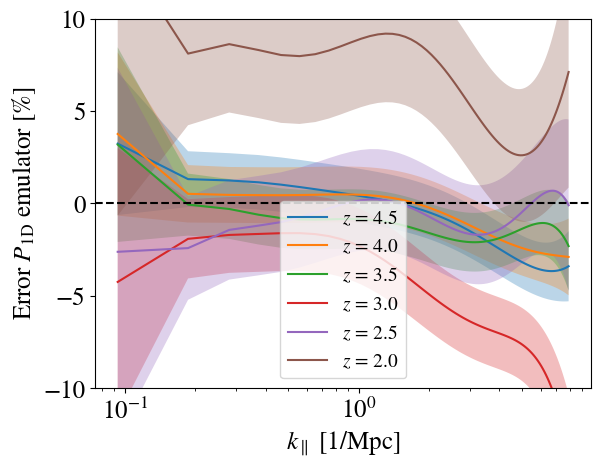

In [37]:
for i in np.arange(0,11,2):
#for i in range(0,1):

    plt.plot(emulator.sim_k_Mpc[:85],fractional_errors[-1,i], label = f'$z$ = {zs[i]}')
    plt.fill_between(emulator.sim_k_Mpc[:85],fractional_errors[-1,i]-emu_p1derrs[-1,i]/true_p1ds[-1,i]*100, fractional_errors[-1,i]+emu_p1derrs[-1,i]/true_p1ds[-1,i]*100 , alpha=0.3)

plt.ylim(-10,10)
#plt.fill_between(emulator.sim_k_Mpc[:85],-1,1, color='grey', alpha=0.2)
plt.legend(fontsize=14,loc = 8)
plt.ylabel(r'Error $P_{\rm 1D}$ emulator [%]', fontsize=18)
plt.xlabel(r'$k_{\parallel}$ [1/Mpc]', fontsize=18)
plt.axhline(ls='--', y=0, color ='black')
plt.xscale('log')
plt.savefig('P18_k_v2.pdf',bbox_inches='tight')

In [23]:
emu_p1derrs[-1].mean() / emu_p1derrs[0].mean()

0.7041497363385248

In [24]:
emu_p1derrs[0].mean()

0.003498658711452692